In [3]:
import Pkg; Pkg.activate(".")

  Activating project at `~/SAFT_ML`


In [4]:
using Clapeyron
includet("./saftvrmienn.jl")
import Clapeyron: a_res

using MolecularGraph, Graphs
using Plots

using Flux
# using Flux: onecold, onehotbatch, logitcrossentropy
using Flux: DataLoader
using GraphNeuralNetworks
using ForwardDiff, Zygote, ChainRulesCore

using MLUtils
using OneHotArrays
# using LinearAlgebra, Random, Statistics
using Statistics, Random

In [5]:
# atom_symbol(mol): atom letters as a symbol e.g. :C, :O and :N
# charge(mol): electric charge of the atom. only integer charge is allowed in the model
# multiplicity(mol): 1: no unpaired electron(default), 2: radical, 3: biradical
# lone_pair(mol): number of lone pair on the atom
# implicit_hydrogens(mol): number of implicit hydrogens that are not appear as graph vertices but automatically calculated, drawn in image and used for calculation of other descriptors.
# valence(mol): number of atom valence, specific to each atom species and considering electric charge. Implicit number of hydrogens is obtained by subtracting the degree of the vertex from the valence.
# is_aromatic(mol): whether the atom is aromatic or not. only binary aromaticity is allowed in the model.
# pi_electron(mol): number of pi electrons
# hybridization(mol): orbital hybridization e.g. sp, sp2 and sp3

In [6]:
function make_graph_from_smiles(smiles::String)
    molgraph = smilestomol(smiles)

    g = Graph(nv(molgraph))
    for e in edges(molgraph)
        add_edge!(g, e.src, e.dst)
    end

    # Should number of hydrogens be one-hot encoded?
    f(vec, enc) = hcat(map(x -> onehot(x, enc), vec)...)
    num_h = f(implicit_hydrogens(molgraph), [0, 1, 2, 3, 4])
    hybrid = f(hybridization(molgraph), [:sp, :sp2, :sp3])
    atoms = f(atom_symbol(molgraph), [:C, :O, :N])
    # pi_electron = f()

    # Node data should be matrix (num_features, num_nodes)
    # Matrix has num_nodes columns, num_features rows
    ndata = Float32.(vcat(num_h, hybrid, atoms))

    g = GNNGraph(g, ndata = ndata, edata = nothing)
    return g
end

g = make_graph_from_smiles("CC=CC(CC=O)")

GNNGraph:
  num_nodes: 7
  num_edges: 12
  ndata:
	x = 11×7 Matrix{Float32}

In [7]:
model = SAFTVRMie(["methane"])
fieldnames(typeof(model.params.Mw))
model.params.Mw.values[1]

16.04

In [8]:
# Iterate over molecules in dataset and build graph for each one
# Initially sample data for hydrocarbons
#! isobutane, isopentane not defined for SAFTVRMie
species = [
    "methane",
    "ethane",
    "propane",
    "butane",
    # "pentane",
    # "hexane",
    # "heptane",
    # "octane",
    # "nonane",
    # "decane",
]

# Define smiles map
smiles_map = Dict(
    "methane" => "C",
    "ethane" => "CC",
    "propane" => "CCC",
    "butane" => "CCCC",
    "isobutane" => "CC(C)C",
    "pentane" => "CCCCC",
    "isopentane" => "CC(C)CC",
    "hexane" => "CCCCCC",
    "heptane" => "CCCCCCC",
    "octane" => "CCCCCCCC",
    "nonane" => "CCCCCCCCC",
    "decane" => "CCCCCCCCCC",
)

# Create training data, currently sampled along saturation curve

T = GNNGraph{Tuple{Vector{Int64}, Vector{Int64}, Nothing}}
graphs = T[]
states = Vector{Float32}[]
Y_data = Float32[]

n = 30
for s in species
    # model = GERG2008([s])
    model = SAFTVRMie([s])
    Tc, pc, Vc = crit_pure(model)
    smiles = smiles_map[s]

    # fingerprint = make_fingerprint(smiles)
    g = make_graph_from_smiles(smiles)

    T_range = range(0.5 * Tc, 0.99 * Tc, n)
    # V_range = range(0.5 * Vc, 1.5 * Vc, n) # V could be sampled from a logspace
    for T in T_range
        (p₀, V_vec...) = saturation_pressure(model, T)
        for V in V_vec
            push!(graphs, g)

            Mw = model.params.Mw.values[1]
            m = model.params.segment.values[1]
            push!(states, [V, T, Mw, m])

            a = a_res(model, V, T, [1.0])
            @assert !isnan(a) "a is NaN at $(V), $(T), $s"
            push!(Y_data, a)
        end
    end
end

In [9]:
n = 10
display(graphs[n])
display(states[n])
display(Y_data[n])
nothing

GNNGraph:
  num_nodes: 1
  num_edges: 0
  ndata:
	x = 11×1 Matrix{Float32}

4-element Vector{Float32}:
   0.009401684
 110.93587
  16.04
   1.0

-0.027122194f0

In [10]:
train_data, test_data = splitobs((graphs, states, Y_data), at = 0.8, shuffle = true) |> getobs

Random.seed!(0)
train_loader = DataLoader(train_data, batchsize = 32, shuffle = true)
test_loader = DataLoader(test_data, batchsize = 32, shuffle = false)

# Testing if batching works. This will be used when training
# This should produce a single GNNGraph object with a matrix of ndata
vec_gs, _ = first(train_loader)
MLUtils.batch(vec_gs)

GNNGraph:
  num_nodes: 76
  num_edges: 88
  num_graphs: 32
  ndata:
	x = 11×76 Matrix{Float32}

In [11]:
function differentiable_saft(X::AbstractVector{T}, Vol, Temp, Mw, m) where {T<:Real}
    model = SAFTVRMieNN(
        params=SAFTVRMieNNParams(
            Mw=[Mw],
            segment=[m], # (C - 4)/(3) + 1
            sigma=[X[1]] * 1f-10,
            lambda_a=[6.0], # Fixing at 6. Simple molecules interacting through London dispersion -> Should have λₐ = 6.
            lambda_r=[X[2]],
            epsilon=[X[3]],
            # Required for association
            epsilon_assoc=Float32[],
            bondvol=Float32[],
        )
    )
    return a_res(model, Vol, Temp, [1.0])
end

function ChainRulesCore.rrule(::typeof(differentiable_saft), x, V, T, Mw, m)
    y = differentiable_saft(x, V, T, Mw, m)

    function f_pullback(Δy)
        # Use ForwardDiff to compute the gradient
        ∂x = @thunk(ForwardDiff.gradient(x -> differentiable_saft(x, V, T, Mw, m), x) .* Δy)
        ∂V = @thunk(ForwardDiff.derivative(V -> differentiable_saft(x, V, T, Mw, m), V) * Δy)
        ∂T = @thunk(ForwardDiff.derivative(T -> differentiable_saft(x, V, T, Mw, m), T) * Δy)
        ∂Mw = @thunk(ForwardDiff.derivative(Mw -> differentiable_saft(x, V, T, Mw, m), Mw) * Δy)
        ∂m = @thunk(ForwardDiff.derivative(m -> differentiable_saft(x, V, T, Mw, m), m) * Δy)
        return (NoTangent(), ∂x, ∂V, ∂T, ∂Mw, ∂m)
    end

    return y, f_pullback
end

In [12]:
#? Works for evaluation, fails for gradients
X = [3.737, 12.504, 152.58]
@show differentiable_saft(X, 1e-4, 300, 14.0, 1.0)
@show ForwardDiff.gradient(x -> differentiable_saft(x, 1e-4, 300, 14.0, 1.0), X)
@show Zygote.gradient(x -> differentiable_saft(x, 1e-4, 300, 14.0, 1.0), X)

differentiable_saft(X, 0.0001, 300, 14.0, 1.0) = -0.2883850024854241
ForwardDiff.gradient((x->begin
            #= /home/luc/SAFT_ML/4_gnn_saft.ipynb:4 =#
            differentiable_saft(x, 0.0001, 300, 14.0, 1.0)
        end), X) = 

[-0.12769665985165313, 0.053698346998990246, -0.0064937953559046635]


Zygote.gradient((x->begin
            #= /home/luc/SAFT_ML/4_gnn_saft.ipynb:5 =#
            differentiable_saft(x, 0.0001, 300, 14.0, 1.0)
        end), X) = ([-0.12769665985165313, 0.053698346998990246, -0.0064937953559046635],)


([-0.12769665985165313, 0.053698346998990246, -0.0064937953559046635],)

In [68]:
function create_model(nin, nh, nout=3, nhlayers=5)
    GNNChain(
        GraphConv(nin => nh, relu),
        [GraphConv(nh => nh, relu) for _ in 1:nhlayers]...,
        # GraphConv(nh => nh, relu),
        # GraphConv(nh => nh, relu),
        # GraphConv(nh => nh, relu),
        GraphConv(nh => nh),
        GlobalPool(mean), # Average the node features
        Dropout(0.2),
        Dense(nh, nout),
    )
end

function bound_output(X, lb, ub, b=10.0)
    return @. lb + (ub - lb) * 0.5 * (tanh(1 / b * (X - lb) / (ub - lb)) + 1)
end

function predict_a_res(X, V, T, Mw, m)
    # Bound output
    bounds = Tuple{Float32,Float32}[
        (2.5, 5), # σ
        (10, 14), # λ_r
        (150, 300), # ϵ
    ]
    # ŷ = mean(X)
    X_bounded = bound_output(X, first.(bounds), last.(bounds))
    ŷ = differentiable_saft(X_bounded, V, T, Mw, m)
    return ŷ
end

function eval_loss(model, data_loader, device)
    loss = 0.0
    for (g, state, y) in data_loader
        g, state, y = MLUtils.batch(g) |> device, state |> device, y |> device

        X = model(g, g.ndata.x)'
        ŷ = predict_a_res(X, state...)
        loss += Flux.mse(ŷ, y)
    end
    return loss / length(data_loader)
end

function train!(model; epochs=100, η=1e-3, infotime=20, log_loss=false)
    # device = Flux.gpu # uncomment this for GPU training
    device = Flux.cpu
    model = model |> device
    opt = ADAM(1e-3)

    function report(epoch)
        train = eval_loss(model, train_loader, device)
        test = eval_loss(model, test_loader, device)
        @info (; epoch, train, test)
    end

    epoch_loss_vec = Float32[]
    # report(0)
    for epoch in 1:epochs
        epoch_loss = 0.0
        for (g, state, y) in train_loader
            g, state, y = MLUtils.batch(g) |> device, state |> device, y |> device

            batch_loss = 0.0
            loss_fn() = begin
                X = model(g, g.ndata.x)
                # ŷ = [predict_a_res(Xᵢ, stateᵢ...) for (Xᵢ, stateᵢ) in zip(eachcol(X), state)]
                for (Xᵢ, stateᵢ, yᵢ) in zip(eachcol(X), state, y)
                    V, T, Mw, m = stateᵢ
                    ŷ = predict_a_res(Xᵢ, V, T, Mw, m)
                    batch_loss += ((ŷ - yᵢ) / yᵢ)^2
                    @assert batch_loss isa Real "Loss is not a real number, got $(typeof(loss)), X_pred = $X_pred"
                    @assert !isnan(batch_loss) "Loss is NaN, X_pred = $X_pred"
                end
                # @show batch_loss
                # loss = Flux.mse(ŷ, y)
                # loss = @. (ŷ - y)^2
                # @show loss, typeof(loss)
                # loss
                batch_loss /= length(state)
            end

            grads = Zygote.gradient(Flux.params(model)) do
                loss_fn()
            end
            epoch_loss += batch_loss
            # @show grads
            Flux.update!(opt, Flux.params(model), grads)
        end
        epoch_loss /= length(train_loader)
        # epoch % infotime == 0 && @show epoch, epoch_loss
        push!(epoch_loss_vec, epoch_loss)
        @show epoch, epoch_loss
        # epoch % infotime == 0 && report(epoch)
    end
    return epoch_loss_vec
end

train! (generic function with 1 method)

In [69]:
nin = 11
nh = 128
model = create_model(nin, nh)
epoch_loss_vec = train!(model)
nothing

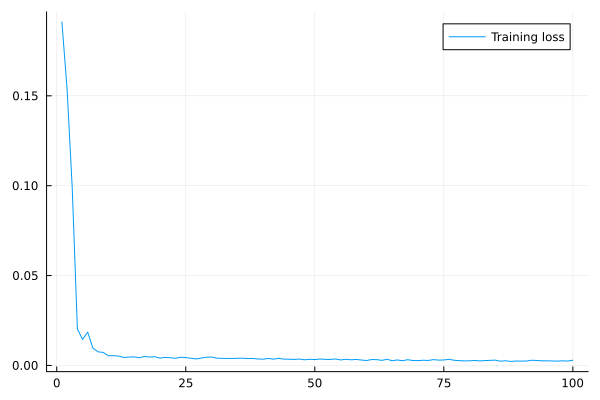

In [71]:
plot(epoch_loss_vec, label = "Training loss")

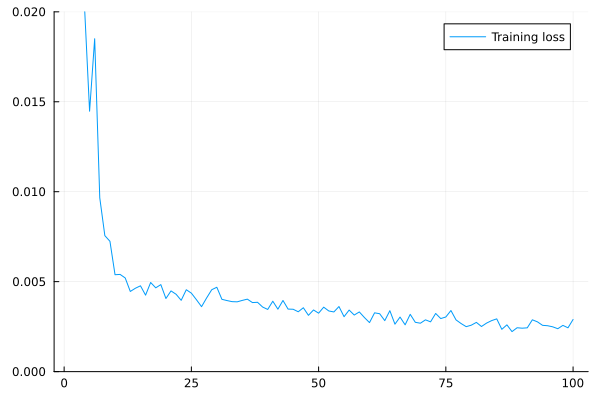

In [72]:
plot(epoch_loss_vec, label = "Training loss", ylims=(0.0, 0.02))